In [1]:
from unidecode import unidecode

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# 1. Importação e junção dos datasets

## 1.1. Dados de Internet

### SIMET_VELOC
- **cod_setor:** setor censitário da região avaliada.
- **lat, lon:** coordenadas geográficas.
- **asn:** código da operadora.
- **asn_name:** nome da operadora.
- **type:** tipo de conexão -- *broadband* para banda-larga fixa, *mobile* para banda-larga móvel.
- **numDisps:** número de dispositivos que compõem a amostra.
- **tcp_range_(velocidade):** número de dispositivos por faixa de velocidade de download, em Mb/s.

### DIC_IBGE
- **cod_setor:** setor censitário da região.
- **cod_ap:** área de ponderação da região.
- **cod_mun:** código do município.
- **nom_mun:** nome completo do município.
- **sig_uf:** sigla da unidade federativa.

Os códigos de geolocalização `cod_mun`, `cod_ap` e `cod_setor` são compilados pelo IBGE e disponibilizados na página sobre [Malha de Setores Censitários](https://www.ibge.gov.br/geociencias/organizacao-do-territorio/malhas-territoriais/26565-malhas-de-setores-censitarios-divisoes-intramunicipais.html?=&t=o-que-e).

In [2]:
def classifica_uf(x):
    if x in ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC']:
        return 'NORTE'
    if x in ['MA', 'PI', 'CE', 'RN', 'PE', 'PB', 'SE', 'AL', 'BA']:
        return 'NORDESTE'
    if x in ['MT', 'MS', 'GO', 'DF']:
        return 'CENTRO-OESTE'
    if x in ['MG', 'SP', 'RJ', 'ES']:
        return 'SUDESTE'
    if x in ['SC', 'PR', 'RS']:
        return 'SUL'

In [3]:
def soma_tcp_range(df, start, stop):
    col_soma = pd.Series(np.zeros(len(df)))
    
    while start <= stop:
        try:
            col_soma += df['tcp_range_' + str(start)]
        except KeyError:
            pass
        start += 0.5
        
    return col_soma

### 1.1.1 Importação e geolocalização

In [20]:
internet_connection = pd.read_parquet('datasets/raw/internet_connection.parquet')
display(internet_connection.head())

dicionario_ibge = pd.read_parquet('datasets/raw/dicionario_ibge.parquet')
display(dicionario_ibge.head())

,cod_setor,asn,asn_name,type,numDisps,"tcp_range_0,5",tcp_range_1,"tcp_range_1,5",tcp_range_2,"tcp_range_2,5",...,tcp_range_10,tcp_range_11,tcp_range_12,tcp_range_15,tcp_range_20,tcp_range_25,tcp_range_35,tcp_range_40,tcp_range_45,tcp_range_50
0,330070405000288,NaN,Todos ASN,broadband,4,0,0,0,0,NaN,...,0,NaN,NaN,1,1.0,0.0,0.0,NaN,NaN,1.0
1,330070405000288,18881.0,TELEFONICA BRASIL S.A,broadband,1,0,0,0,0,NaN,...,0,NaN,NaN,0,0.0,0.0,0.0,NaN,NaN,1.0
2,330070405000288,28210.0,VM OPENLINK COMUNICACAO MULTIMIDIA S.A.,broadband,1,0,0,0,0,NaN,...,0,NaN,NaN,1,0.0,0.0,0.0,NaN,NaN,0.0
3,330070405000288,267416.0,PIENSCO MANUTENCAO E PROJETOS LTDA,broadband,1,0,0,0,0,NaN,...,0,NaN,NaN,0,0.0,0.0,0.0,NaN,NaN,0.0
4,330070405000288,7738.0,Telemar Norte Leste S.A.,broadband,1,0,0,0,0,NaN,...,0,NaN,NaN,0,1.0,0.0,0.0,NaN,NaN,0.0


,cod_setor,cod_ap,cod_mun,nom_mun,sig_uf
0,120001305000011,1.200013e+12,1200013,ACRELANDIA,AC
1,120001305000006,1.200013e+12,1200013,ACRELANDIA,AC
2,120001305000010,1.200013e+12,1200013,ACRELANDIA,AC
3,120001305000002,1.200013e+12,1200013,ACRELANDIA,AC
4,120001305000016,1.200013e+12,1200013,ACRELANDIA,AC


In [21]:
dicionario_ibge['nom_mun'] = dicionario_ibge['nom_mun'].apply(lambda x: unidecode(x))
dicionario_ibge['regiao'] = dicionario_ibge['sig_uf'].apply(classifica_uf)
internet_connection.columns = internet_connection.columns.str.replace(',', '.')
internet_connection = internet_connection.rename(columns=dict(
    zip(
        [x for x in internet_connection.columns if 'tcp_range' in x and '.' not in x],
        [x + str('.0') for x in internet_connection.columns if 'tcp_range' in x and '.' not in x]
    )
))
internet_connection = internet_connection.merge(dicionario_ibge, how='inner', on='cod_setor')
internet_connection.head()

,cod_setor,asn,asn_name,type,numDisps,tcp_range_0.5,tcp_range_1.0,tcp_range_1.5,tcp_range_2.0,tcp_range_2.5,...,tcp_range_25.0,tcp_range_35.0,tcp_range_40.0,tcp_range_45.0,tcp_range_50.0,cod_ap,cod_mun,nom_mun,sig_uf,regiao
0,330070405000288,NaN,Todos ASN,broadband,4,0,0,0,0,NaN,...,0.0,0.0,NaN,NaN,1.0,3.300704e+12,3300704,CABO FRIO,RJ,SUDESTE
1,330070405000288,18881.0,TELEFONICA BRASIL S.A,broadband,1,0,0,0,0,NaN,...,0.0,0.0,NaN,NaN,1.0,3.300704e+12,3300704,CABO FRIO,RJ,SUDESTE
2,330070405000288,28210.0,VM OPENLINK COMUNICACAO MULTIMIDIA S.A.,broadband,1,0,0,0,0,NaN,...,0.0,0.0,NaN,NaN,0.0,3.300704e+12,3300704,CABO FRIO,RJ,SUDESTE
3,330070405000288,267416.0,PIENSCO MANUTENCAO E PROJETOS LTDA,broadband,1,0,0,0,0,NaN,...,0.0,0.0,NaN,NaN,0.0,3.300704e+12,3300704,CABO FRIO,RJ,SUDESTE
4,330070405000288,7738.0,Telemar Norte Leste S.A.,broadband,1,0,0,0,0,NaN,...,0.0,0.0,NaN,NaN,0.0,3.300704e+12,3300704,CABO FRIO,RJ,SUDESTE


### 1.1.2. Agregação por município
Aqui, agrupamos os registros por município e tipo de conexão, e somamos o total de dispositivos por faixa de velocidade (`tcp_range_...`).

In [22]:
tcp_range_cols = [x for x in internet_connection.columns.tolist() if 'tcp_range' in x]
agg_dict = {key: 'sum' for key in tcp_range_cols}
agg_dict['asn_name'] = 'nunique'

internet_connection_grp = internet_connection.groupby(['cod_mun', 'type', 'nom_mun', 'sig_uf', 'regiao']).agg(agg_dict).reset_index().rename(columns={'asn_name': 'num_operadoras'})
internet_connection_grp.head()

,cod_mun,type,nom_mun,sig_uf,regiao,tcp_range_0.5,tcp_range_1.0,tcp_range_1.5,tcp_range_2.0,tcp_range_2.5,...,tcp_range_11.0,tcp_range_12.0,tcp_range_15.0,tcp_range_20.0,tcp_range_25.0,tcp_range_35.0,tcp_range_40.0,tcp_range_45.0,tcp_range_50.0,num_operadoras
0,1100015,broadband,ALTA FLORESTA D'OESTE,RO,NORTE,26,0,0,0,0.0,...,0.0,0.0,0,0.0,0.0,22.0,0.0,0.0,0.0,3
1,1100023,broadband,ARIQUEMES,RO,NORTE,20,34,0,0,0.0,...,0.0,0.0,12,36.0,27.0,66.0,0.0,0.0,96.0,7
2,1100023,mobile,ARIQUEMES,RO,NORTE,0,0,0,0,0.0,...,0.0,10.0,22,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1100049,broadband,CACOAL,RO,NORTE,0,0,26,32,0.0,...,0.0,0.0,0,0.0,42.0,84.0,0.0,0.0,340.0,5
4,1100049,mobile,CACOAL,RO,NORTE,16,0,0,0,0.0,...,0.0,0.0,32,0.0,0.0,0.0,0.0,0.0,0.0,3


### 1.1.3. Agregação por faixas amplas de velocidade

In [23]:
internet_connection_grp['0_a_2_mbs'] = soma_tcp_range(internet_connection_grp, 0, 2)
internet_connection_grp['2.5_a_5_mbs'] = soma_tcp_range(internet_connection_grp, 2.5, 5)
internet_connection_grp['6_a_10_mbs'] = soma_tcp_range(internet_connection_grp, 6, 10)
internet_connection_grp['11_a_15_mbs'] = soma_tcp_range(internet_connection_grp, 11, 15)
internet_connection_grp['15_a_25_mbs'] = soma_tcp_range(internet_connection_grp, 16, 25)
internet_connection_grp['acima_25_mbs'] = soma_tcp_range(internet_connection_grp, 26, 50)
internet_connection_grp['0_a_10_mbs'] = soma_tcp_range(internet_connection_grp, 0, 10)
internet_connection_grp['acima_10_mbs'] = soma_tcp_range(internet_connection_grp, 10, 50)

In [24]:
internet_connection_grp = internet_connection_grp.drop(columns=[x for x in internet_connection_grp if 'tcp_range' in x])
internet_connection_grp.head()

,cod_mun,type,nom_mun,sig_uf,regiao,num_operadoras,0_a_2_mbs,2.5_a_5_mbs,6_a_10_mbs,11_a_15_mbs,15_a_25_mbs,acima_25_mbs,0_a_10_mbs,acima_10_mbs
0,1100015,broadband,ALTA FLORESTA D'OESTE,RO,NORTE,3,26.0,0.0,0.0,0.0,0.0,22.0,26.0,22.0
1,1100023,broadband,ARIQUEMES,RO,NORTE,7,54.0,94.0,86.0,12.0,63.0,162.0,234.0,237.0
2,1100023,mobile,ARIQUEMES,RO,NORTE,1,0.0,14.0,24.0,32.0,0.0,0.0,38.0,32.0
3,1100049,broadband,CACOAL,RO,NORTE,5,58.0,72.0,0.0,0.0,42.0,424.0,130.0,466.0
4,1100049,mobile,CACOAL,RO,NORTE,3,16.0,32.0,0.0,32.0,0.0,0.0,48.0,32.0


## 1.2. Dados de Educação

### DIC_IBGE
- **cod_setor:** setor censitário da região.
- **cod_ap:** área de ponderação da região.
- **cod_mun:** código do município.
- **nom_mun:** nome completo do município.
- **sig_uf:** sigla da unidade federativa.

Os códigos de geolocalização `cod_mun`, `cod_ap` e `cod_setor` são compilados pelo IBGE e disponibilizados na página sobre [Malha de Setores Censitários](https://www.ibge.gov.br/geociencias/organizacao-do-territorio/malhas-territoriais/26565-malhas-de-setores-censitarios-divisoes-intramunicipais.html?=&t=o-que-e).
Este dataframe é o mesmo utilizado na seção anterior.

In [25]:
def remove_multilevel_index(df):
    for i in range(len(df.columns.values)):
        col = list(df.columns.values[i])

        # Transforma títulos em string
        for j in range(3):
            col[j] = str(col[j])

        # Retira títulos vazios
        for j in range(3):
            if 'Unnamed' in col[j]:
                col[j] = ""

        col = tuple(col)
        df.columns.values[i] = col

    # Junta os títulos hierárquicos em um só
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    
    return df

### 1.2.1. IDEB para anos iniciais

In [10]:
dados_ideb_ef_1 = pd.read_excel('datasets/raw/divulgacao_anos_iniciais_municipios_2019.xlsx',
                                header = [6, 7, 8])

dados_ideb_ef_1 = remove_multilevel_index(dados_ideb_ef_1)
dados_ideb_ef_1 = dados_ideb_ef_1[dados_ideb_ef_1['Rede'] == 'Pública'][[
    'Código do Município',
    'Taxa de Aprovação - 2019  5º',
    'Nota SAEB - 2019 Matemática',
    'Nota SAEB - 2019 Língua Portuguesa',
    'IDEB\n2019\n(N x P)'
]].rename(columns={
    'Código do Município': 'cod_mun',
    'Taxa de Aprovação - 2019  5º': 'tx_aprov_ef_1',
    'Nota SAEB - 2019 Matemática': 'saeb_mat_ef_1',
    'Nota SAEB - 2019 Língua Portuguesa': 'saeb_port_ef_1',
    'IDEB\n2019\n(N x P)': 'ideb_ef_1'
}).reset_index(drop=True)

dados_ideb_ef_1.head()

,cod_mun,tx_aprov_ef_1,saeb_mat_ef_1,saeb_port_ef_1,ideb_ef_1
0,1100015,92.4,226.44,204.7,5.7
1,1100023,88.7,214.18,199.92,5.2
2,1100031,86.8,216.56,201.97,5.1
3,1100049,98,223.45,209.48,5.8
4,1100056,97.8,245.81,227.03,6.4


In [11]:
#Importa dados do IDEB (anos finais)
dados_ideb_ef_2 = pd.read_excel('datasets/raw/divulgacao_anos_finais_municipios_2019.xlsx',
                                header = [6, 7, 8])

dados_ideb_ef_2 = remove_multilevel_index(dados_ideb_ef_2)
dados_ideb_ef_2 = dados_ideb_ef_2[dados_ideb_ef_2['Rede'] == 'Pública'][[
    'Código do Município',
    'Taxa de Aprovação - 2019  9º',
    'Nota SAEB - 2019 Matemática',
    'Nota SAEB - 2019 Língua Portuguesa',
    'IDEB\n2019\n(N x P)'
]].rename(columns={
    'Código do Município': 'cod_mun',
    'Taxa de Aprovação - 2019  9º': 'tx_aprov_ef_2',
    'Nota SAEB - 2019 Matemática': 'saeb_mat_ef_2',
    'Nota SAEB - 2019 Língua Portuguesa': 'saeb_port_ef_2',
    'IDEB\n2019\n(N x P)': 'ideb_ef_2'
}).reset_index(drop=True)

dados_ideb_ef_2.head()

,cod_mun,tx_aprov_ef_2,saeb_mat_ef_2,saeb_port_ef_2,ideb_ef_2
0,1100015,95.3,270.02,265.1,5.2
1,1100023,93.7,266.09,265.26,5.1
2,1100031,94.2,242.44,241.04,4.6
3,1100049,98.3,267.51,260.58,5.3
4,1100056,97.3,268.57,261.62,5.3


In [12]:
#Importa dados do IDEB (ensino médio)
dados_ideb_em = pd.read_excel('datasets/raw/divulgacao_ensino_medio_municipios_2019.xlsx',
                              header = [6, 7, 8])

dados_ideb_em = remove_multilevel_index(dados_ideb_em)
dados_ideb_em = dados_ideb_em[dados_ideb_em['Rede'] == 'Pública'][[
    'Código do Município',
    'Taxa de Aprovação - 2019  Total',
    'Nota SAEB - 2019 Matemática',
    'Nota SAEB - 2019 Língua Portuguesa',
    'IDEB\n2019\n(N x P)'
]].rename(columns={
    'Código do Município': 'cod_mun',
    'Taxa de Aprovação - 2019  Total': 'tx_aprov_em',
    'Nota SAEB - 2019 Matemática': 'saeb_mat_em',
    'Nota SAEB - 2019 Língua Portuguesa': 'saeb_port_em',
    'IDEB\n2019\n(N x P)': 'ideb_em'
}).reset_index(drop=True)

dados_ideb_em.head()

,cod_mun,tx_aprov_em,saeb_mat_em,saeb_port_em,ideb_em
0,1100015,92.2,285.14,278.52,4.5
1,1100023,83.4,278.58,278.78,4
2,1100031,94.8,ND,ND,-
3,1100049,91.5,282.99,278.36,4.4
4,1100056,90.7,288.99,283.11,4.6


## 1.3. Indicadores sociais

In [13]:
#Importa variáveis de controle para os municípios
indicadores_sociais = pd.read_csv("datasets/raw/indicadores_sociais.csv",
                                  sep = ',')
censo_populacao = pd.read_excel('datasets/raw/pop_censo_2010.xlsx')

#Vamos selecionar variáveis de anos diferentes:
#Censo 2010 (% de pobres, taxa de analfabetismo)
#DataSUS 2017 (Taxa de mortalidade infantil, % de meninas que tiveram filhos)
#RAIS 2016 (PIB per capita)
indicadores_sociais = indicadores_sociais.merge(censo_populacao, on='Territorialidades', how='inner')
indicadores_sociais = indicadores_sociais[[
    'Territorialidades',
    'População total 2010',
    'Esperança de vida ao nascer 2010',
    'Taxa de analfabetismo - 15 anos ou mais de idade 2010',
    '% de pobres 2010', 
    'Produto Interno Bruto per capita 2016',
    'Taxa de mortalidade infantil 2017',
    '% de meninas de 10 a 14 anos de idade que tiveram filhos 2017'
]].rename(columns={
    'Territorialidades': 'nom_mun',
    'População total 2010': 'populacao',
    'Esperança de vida ao nascer 2010': 'exp_vida',
    'Taxa de analfabetismo - 15 anos ou mais de idade 2010': 'analfabetismo',
    '% de pobres 2010': 'tx_pobreza',
    'Produto Interno Bruto per capita 2016': 'pib_per_capita',
    'Taxa de mortalidade infantil 2017': 'mortalidade_inf',
    '% de meninas de 10 a 14 anos de idade que tiveram filhos 2017': 'maternidade_inf'
}).reset_index(drop=True)

indicadores_sociais['sig_uf'] = indicadores_sociais['nom_mun'].apply(lambda x: str(x)[-3:-1])
indicadores_sociais['nom_mun'] = indicadores_sociais['nom_mun'].apply(lambda x: unidecode(str(x)[:-5].upper()))

indicadores_sociais.head()

,nom_mun,populacao,exp_vida,analfabetismo,tx_pobreza,pib_per_capita,mortalidade_inf,maternidade_inf,sig_uf
0,B,190755799,73.94,9.61,15.20,20.19,12.38,0.76,si
1,ABADIA DE GOIAS,6876,74.82,7.81,6.18,13.72,20.41,0.51,GO
2,ABADIA DOS DOURADOS,6704,75.35,9.12,7.94,16.99,0.00,NaN,MG
3,ABADIANIA,15757,75.46,10.84,8.45,10.38,19.61,1.47,GO
4,ABAETE,22690,75.90,8.72,6.69,12.12,12.30,0.41,MG


### Juntando tudo

In [26]:
df = dados_ideb_ef_1.merge(dados_ideb_ef_2, on='cod_mun', how='inner')\
                    .merge(dados_ideb_em, on='cod_mun', how='inner')\
                    .merge(dicionario_ibge.drop(columns=['cod_ap', 'cod_setor']).drop_duplicates(), on='cod_mun', how='inner')\
                    .merge(indicadores_sociais, on=['nom_mun', 'sig_uf'], how='inner')\
                    .merge(internet_connection_grp, on=['cod_mun', 'nom_mun', 'sig_uf', 'regiao'], how='inner')

df = df.reindex(columns=(
    ['cod_mun', 'nom_mun', 'sig_uf', 'regiao'] + list(
        [x for x in df.columns.tolist() if x not in ['cod_mun', 'nom_mun', 'sig_uf', 'regiao']]
    )
))

df.to_csv('datasets/dataset_pre_limpeza.csv', index=False)
df.head()

,cod_mun,nom_mun,sig_uf,regiao,tx_aprov_ef_1,saeb_mat_ef_1,saeb_port_ef_1,ideb_ef_1,tx_aprov_ef_2,saeb_mat_ef_2,...,type,num_operadoras,0_a_2_mbs,2.5_a_5_mbs,6_a_10_mbs,11_a_15_mbs,15_a_25_mbs,acima_25_mbs,0_a_10_mbs,acima_10_mbs
0,1100015,ALTA FLORESTA D'OESTE,RO,NORTE,92.4,226.44,204.7,5.7,95.3,270.02,...,broadband,3,26.0,0.0,0.0,0.0,0.0,22.0,26.0,22.0
1,1100023,ARIQUEMES,RO,NORTE,88.7,214.18,199.92,5.2,93.7,266.09,...,broadband,7,54.0,94.0,86.0,12.0,63.0,162.0,234.0,237.0
2,1100023,ARIQUEMES,RO,NORTE,88.7,214.18,199.92,5.2,93.7,266.09,...,mobile,1,0.0,14.0,24.0,32.0,0.0,0.0,38.0,32.0
3,1100049,CACOAL,RO,NORTE,98,223.45,209.48,5.8,98.3,267.51,...,broadband,5,58.0,72.0,0.0,0.0,42.0,424.0,130.0,466.0
4,1100049,CACOAL,RO,NORTE,98,223.45,209.48,5.8,98.3,267.51,...,mobile,3,16.0,32.0,0.0,32.0,0.0,0.0,48.0,32.0


# 2. Limpeza dos dados

## 2.1. Dados de educação

In [27]:
cols_educacao = [
    'tx_aprov_ef_1',
    'saeb_mat_ef_1',
    'saeb_port_ef_1',
    'ideb_ef_1',
    'tx_aprov_ef_2',
    'saeb_mat_ef_2',
    'saeb_port_ef_2',
    'ideb_ef_2',
    'tx_aprov_em',
    'saeb_mat_em',
    'saeb_port_em',
    'ideb_em'
]

for col in cols_educacao:
    # Padroniza linhas vazias
    df[col] = df[col].replace('-', np.nan)
    df[col] = df[col].replace('ND', np.nan)
    df[col] = df[col].astype(float)

## 2.2. Indicadores sociais

In [28]:
cols_social = [
    'populacao',
    'exp_vida',
    'analfabetismo',
    'tx_pobreza',
    'pib_per_capita',
    'mortalidade_inf',
    'maternidade_inf'
]

for col in cols_social:
    # Padroniza linhas vazias
    df[col] = df[col].fillna(np.nan)
    df[col] = df[col].astype(float)

## 2.3. Dados de internet

In [29]:
cols_internet = [x for x in df.columns.tolist() if 'mbs' in x]

for col in cols_internet:
    # Padroniza linhas vazias
    df[col] = df[col].fillna(0)
    df[col] = df[col].astype(float)
    
    # Normaliza contagem de dispositivos pela população
    df[col] = df[col] / df['populacao']
    
df['num_operadoras'] = df['num_operadoras'].fillna(0).astype(float)

## 2.4. Salva o DF limpo para analisar

In [30]:
df.to_parquet('datasets/dataset_pos_limpeza.parquet', index=False)
df.head()

,cod_mun,nom_mun,sig_uf,regiao,tx_aprov_ef_1,saeb_mat_ef_1,saeb_port_ef_1,ideb_ef_1,tx_aprov_ef_2,saeb_mat_ef_2,...,type,num_operadoras,0_a_2_mbs,2.5_a_5_mbs,6_a_10_mbs,11_a_15_mbs,15_a_25_mbs,acima_25_mbs,0_a_10_mbs,acima_10_mbs
0,1100015,ALTA FLORESTA D'OESTE,RO,NORTE,92.4,226.44,204.70,5.7,95.3,270.02,...,broadband,3.0,0.001066,0.000000,0.000000,0.000000,0.000000,0.000902,0.001066,0.000902
1,1100023,ARIQUEMES,RO,NORTE,88.7,214.18,199.92,5.2,93.7,266.09,...,broadband,7.0,0.000598,0.001040,0.000952,0.000133,0.000697,0.001793,0.002590,0.002623
2,1100023,ARIQUEMES,RO,NORTE,88.7,214.18,199.92,5.2,93.7,266.09,...,mobile,1.0,0.000000,0.000155,0.000266,0.000354,0.000000,0.000000,0.000421,0.000354
3,1100049,CACOAL,RO,NORTE,98.0,223.45,209.48,5.8,98.3,267.51,...,broadband,5.0,0.000738,0.000916,0.000000,0.000000,0.000535,0.005396,0.001654,0.005931
4,1100049,CACOAL,RO,NORTE,98.0,223.45,209.48,5.8,98.3,267.51,...,mobile,3.0,0.000204,0.000407,0.000000,0.000407,0.000000,0.000000,0.000611,0.000407


In [ ]:
df = pd.read_parquet('datasets/dataset_pos_limpeza.parquet')

# 3. Análise exploratória de dados

## 3.1. Dados de educação

In [23]:
print(u'Dimensões do Dataframe: {}'.format(df.drop_duplicates(subset=cols_educacao).shape))

Dimensões do Dataframe: (3519, 31)


### Visão geral

As colunas do conjunto de variáveis de educação são todas numéricas e contínuas. Aqui, cada sufixo indica o nível de educação considerado:

| Sufixo  | Nível de educação     | Anos escolares     |
| :------ | --------------------- | ------------------ |
| `_ef_1` | Ensino Fundamental I  | 1º ao 5º ano       |
| `_ef_2` | Ensino Fundamental II | 6º ao 9º ano       |
| `_em`   | Ensino Médio          | 1ª, 2ª e 3ª séries |

**Taxa de aprovação (Ens. Fund. I, Ens. Fund. II, Ens. Médio):** observações em pontos percentuais, com uma casa decimal, no intervalo [0.0, 100.0].

**SAEB:** observações representam a nota média, na [escala SAEB](https://academia.qedu.org.br/prova-brasil/454-2/), que varia de acordo com a disciplina e nível de ensino. A tabela abaixo resume as faixas de valores possíveis.

| Nível de ensino       | Língua Portuguesa | Matemática |
| :-------------------- | ----------------- | ---------- |
| Ensino Fundamental I  | 0 a 350           | 125 a 350  |
| Ensino Fundamental II | 200 a 400         | 200 a 425  |
| Ensino Médio          | 225 a 425         | 225 a 475  |

**Ideb:** observações referem-se ao Índice de Desenvolvimento da Educação Básica e admitem valores entre 0 e 10, com uma casa decimal, para todos os níveis de educação.

In [32]:
df[cols_educacao].drop_duplicates(subset=cols_educacao).describe()

,tx_aprov_ef_1,saeb_mat_ef_1,saeb_port_ef_1,ideb_ef_1,tx_aprov_ef_2,saeb_mat_ef_2,saeb_port_ef_2,ideb_ef_2,tx_aprov_em,saeb_mat_em,saeb_port_em,ideb_em
count,3503.000000,3471.000000,3471.000000,3471.000000,3513.000000,3421.000000,3421.000000,3421.000000,3510.00000,3149.000000,3149.000000,3149.000000
mean,94.396717,225.827035,211.697560,5.817776,91.869912,258.889977,255.133213,4.661444,86.08339,274.558263,274.494287,4.070117
std,6.070335,22.068236,19.906565,0.912929,6.113734,17.742040,15.272435,0.714934,8.70051,19.473577,16.398680,0.640029
min,55.900000,159.770000,147.290000,3.300000,52.200000,206.150000,204.260000,2.300000,53.40000,210.860000,221.100000,2.000000
25%,91.300000,209.910000,197.640000,5.100000,88.400000,247.030000,245.090000,4.200000,80.50000,261.700000,263.690000,3.600000
50%,96.500000,226.740000,214.560000,5.900000,93.000000,259.490000,256.240000,4.700000,87.30000,275.940000,276.170000,4.200000
75%,99.200000,241.820000,226.445000,6.500000,96.400000,270.360000,265.520000,5.200000,93.20000,287.660000,286.030000,4.600000
max,100.000000,319.480000,291.330000,9.400000,100.000000,349.210000,315.360000,7.700000,100.00000,342.270000,322.840000,5.800000


### Visualização dos dados

In [34]:
def histograma_educacao(df, key, title, xlabel, bins=None):
    fig, ax = plt.subplots(1, 3, figsize=(17, 5))
    
    if bins is None:
        bins = []
        for i in range(3):
            bins.append(np.linspace(60, 100, 11))

    ax[0].hist(df[key + '_ef_1'], edgecolor='black', bins=bins[0])
    ax[0].axvline(df[key + '_ef_1'].mean(), color='red', linestyle='--')
    ax[0].set_title(u'Ensino Fundamental I')

    ax[1].hist(df[key + '_ef_2'], edgecolor='black', bins=bins[1])
    ax[1].axvline(df[key + '_ef_2'].mean(), color='red', linestyle='--')
    ax[1].set_title(u'Ensino Fundamental II')

    ax[2].hist(df[key + '_em'], edgecolor='black', bins=bins[2])
    ax[2].axvline(df[key + '_em'].mean(), color='red', linestyle='--')
    ax[2].set_title(u'Ensino Médio')
    
    if type(xlabel) is list:
        for i in range(3):
            ax[i].set_xlabel(xlabel[i])
            ax[i].set_ylabel(u'Frequência')
    else:
        for i in range(3):
            ax[i].set_xlabel(xlabel)
            ax[i].set_ylabel(u'Frequência')
        
    fig.suptitle(title, fontsize=14)
    plt.show()
    
def histograma_educacao_decil(df, key, decil, title, xlabel):
    fig, ax = plt.subplots(1, 3, figsize=(17, 5))
    
    bins = df['regiao'].unique().tolist()
    
    if decil > 0:
        df_ef_1 = df[df[key + '_ef_1'] >= df[key + '_ef_1'].quantile(decil)]
        df_ef_1['regiao'].value_counts().plot(kind='bar', ax=ax[0])
        ax[0].set_title(u'Ensino Fundamental I')

        df_ef_2 = df[df[key + '_ef_2'] >= df[key + '_ef_2'].quantile(decil)]
        df_ef_2['regiao'].value_counts().plot(kind='bar', ax=ax[1])
        ax[1].set_title(u'Ensino Fundamental II')

        df_em = df[df[key + '_em'] >= df[key + '_em'].quantile(decil)]
        df_em['regiao'].value_counts().plot(kind='bar', ax=ax[2])
        ax[2].set_title(u'Ensino Médio')
        
    else:
        df_ef_1 = df[df[key + '_ef_1'] <= df[key + '_ef_1'].quantile(-1*decil)]
        df_ef_1['regiao'].value_counts().plot(kind='bar', ax=ax[0])
        ax[0].set_title(u'Ensino Fundamental I')

        df_ef_2 = df[df[key + '_ef_2'] <= df[key + '_ef_2'].quantile(-1*decil)]
        df_ef_2['regiao'].value_counts().plot(kind='bar', ax=ax[1])
        ax[1].set_title(u'Ensino Fundamental II')

        df_em = df[df[key + '_em'] <= df[key + '_em'].quantile(-1*decil)]
        df_em['regiao'].value_counts().plot(kind='bar', ax=ax[2])
        ax[2].set_title(u'Ensino Médio')
    
    if type(xlabel) is list:
        for i in range(3):
            ax[i].set_xlabel(xlabel[i])
            ax[i].set_ylabel(u'Frequência')
    else:
        for i in range(3):
            ax[i].set_xlabel(xlabel)
            ax[i].set_ylabel(u'Frequência')
        
    fig.suptitle(title, fontsize=14)
    plt.show()

#### IDEB

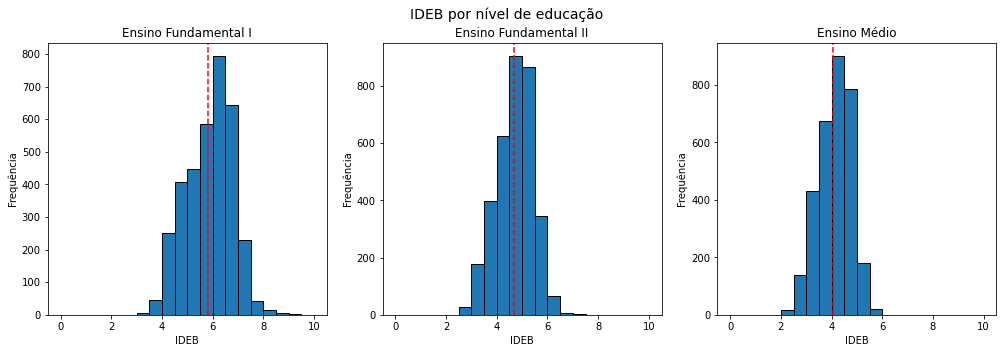

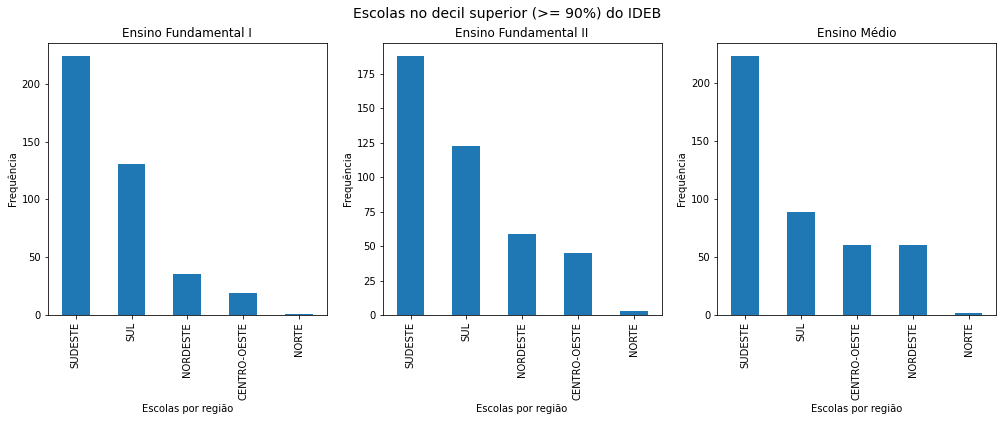

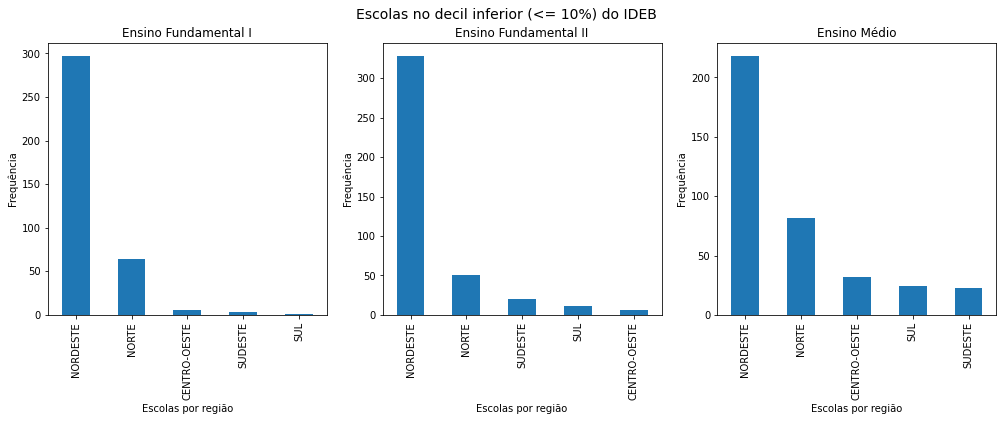

In [35]:
histograma_educacao(
    df=df.drop_duplicates(subset=cols_educacao),
    key='ideb',
    title=u'IDEB por nível de educação',
    xlabel=u'IDEB',
    bins=[
        np.linspace(0, 10, 21),
        np.linspace(0, 10, 21),
        np.linspace(0, 10, 21)
    ]
)

histograma_educacao_decil(
    df=df.drop_duplicates(subset=cols_educacao),
    key='ideb',
    decil=0.9,
    title=u'Escolas no decil superior (>= 90%) do IDEB',
    xlabel=u'Escolas por região'
)

histograma_educacao_decil(
    df=df.drop_duplicates(subset=cols_educacao),
    key='ideb',
    decil=-0.1,
    title=u'Escolas no decil inferior (<= 10%) do IDEB',
    xlabel=u'Escolas por região'
)

#### Taxas de aprovação

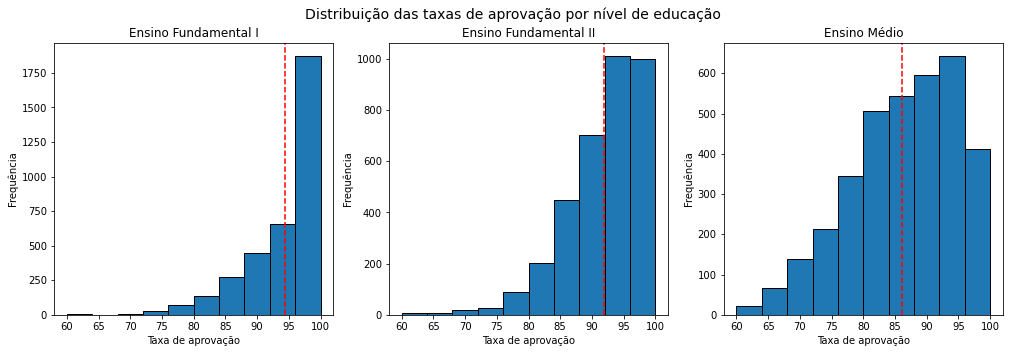

In [36]:
histograma_educacao(
    df=df.drop_duplicates(subset=cols_educacao),
    key='tx_aprov',
    title=u'Distribuição das taxas de aprovação por nível de educação',
    xlabel=u'Taxa de aprovação'
)

#### SAEB - Matemática

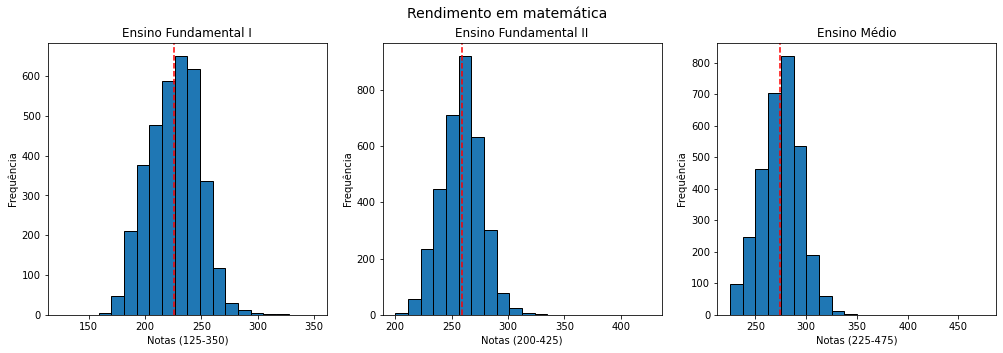

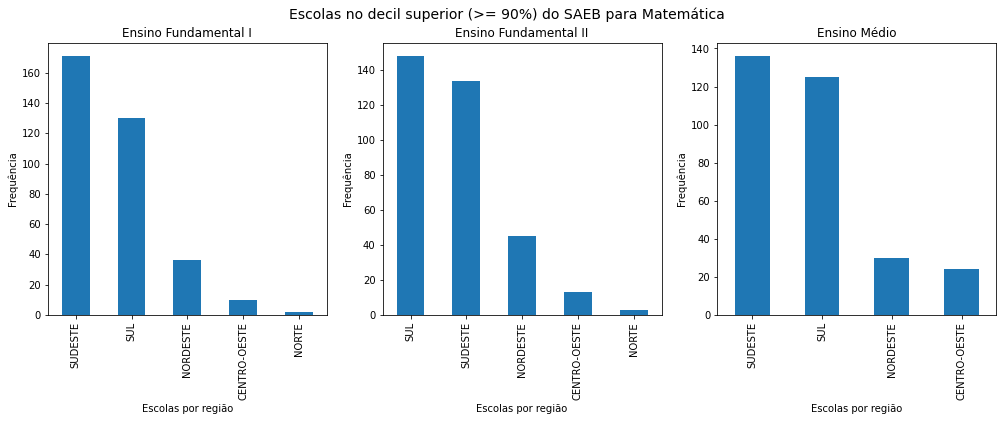

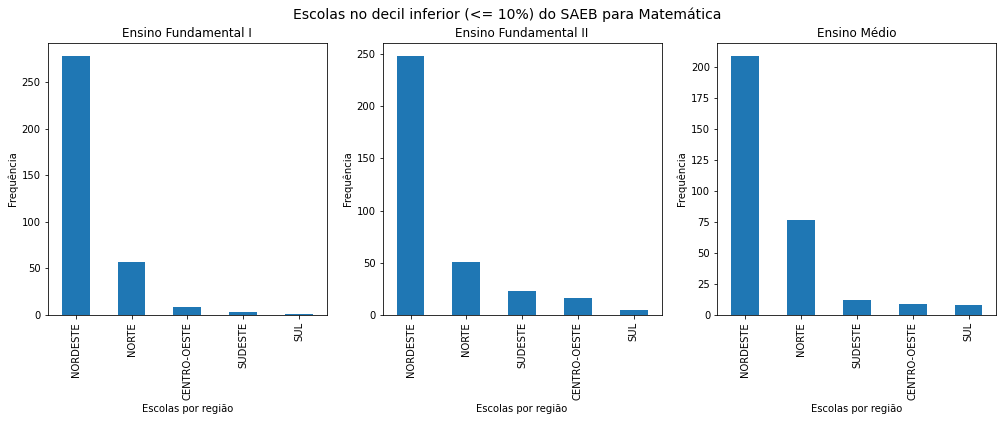

In [37]:
histograma_educacao(
    df=df.drop_duplicates(subset=cols_educacao),
    key='saeb_mat',
    title=u'Rendimento em matemática',
    xlabel=[
        u'Notas (125-350)',
        u'Notas (200-425)',
        u'Notas (225-475)'
    ],
    bins=[
        np.linspace(125, 350, 21),
        np.linspace(200, 425, 21),
        np.linspace(225, 475, 21)
    ]
)

histograma_educacao_decil(
    df=df.drop_duplicates(subset=cols_educacao),
    key='saeb_mat',
    decil=0.9,
    title=u'Escolas no decil superior (>= 90%) do SAEB para Matemática',
    xlabel=u'Escolas por região'
)

histograma_educacao_decil(
    df=df.drop_duplicates(subset=cols_educacao),
    key='saeb_mat',
    decil=-0.1,
    title=u'Escolas no decil inferior (<= 10%) do SAEB para Matemática',
    xlabel=u'Escolas por região'
)

#### SAEB - Língua Portuguesa

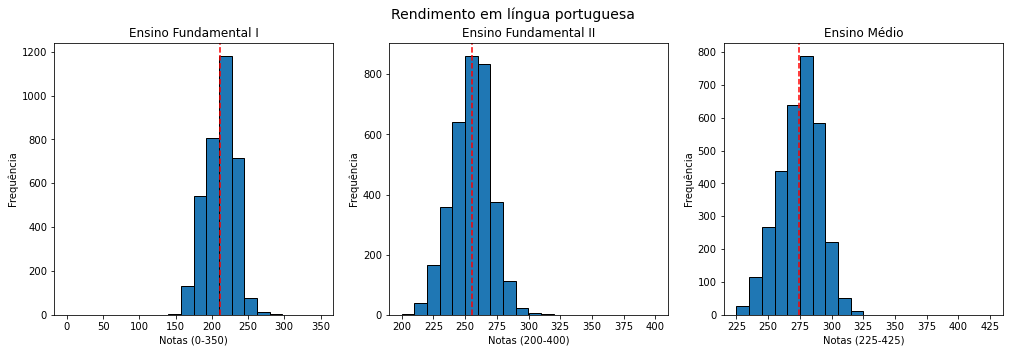

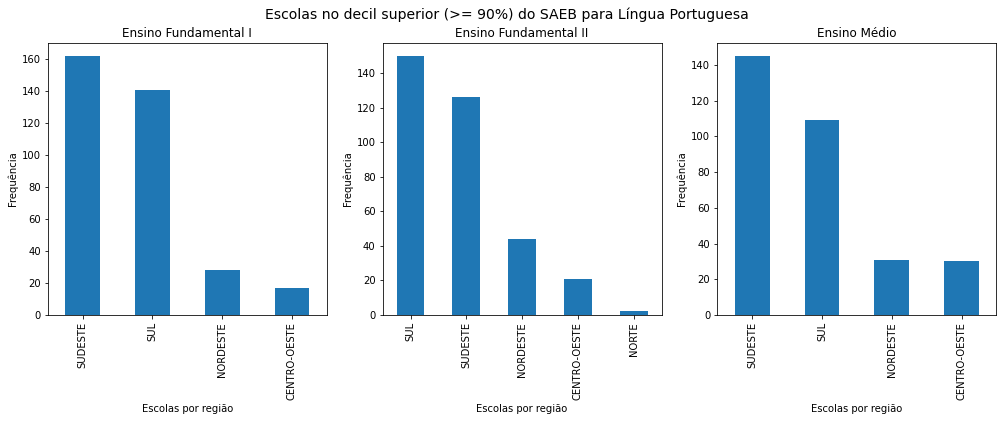

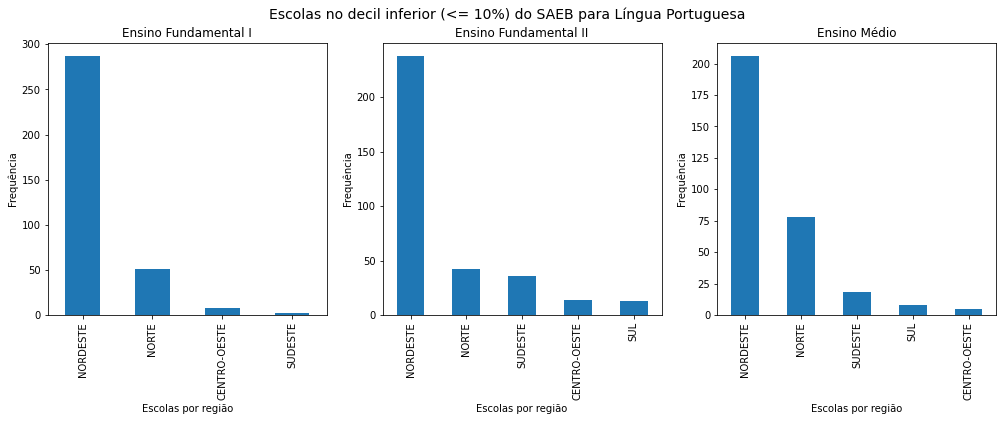

In [38]:
histograma_educacao(
    df=df.drop_duplicates(subset=cols_educacao),
    key='saeb_port',
    title=u'Rendimento em língua portuguesa',
    xlabel=[
        u'Notas (0-350)',
        u'Notas (200-400)',
        u'Notas (225-425)'
    ],
    bins=[
        np.linspace(0, 350, 21),
        np.linspace(200, 400, 21),
        np.linspace(225, 425, 21)
    ]
)

histograma_educacao_decil(
    df=df.drop_duplicates(subset=cols_educacao),
    key='saeb_port',
    decil=0.9,
    title=u'Escolas no decil superior (>= 90%) do SAEB para Língua Portuguesa',
    xlabel=u'Escolas por região'
)

histograma_educacao_decil(
    df=df.drop_duplicates(subset=cols_educacao),
    key='saeb_port',
    decil=-0.1,
    title=u'Escolas no decil inferior (<= 10%) do SAEB para Língua Portuguesa',
    xlabel=u'Escolas por região'
)

### Conclusões

À exceção do indicador de Taxas de Aprovação, as variáveis observadas tem formato aproximadamente de sino aparentemente bem distribuída ao redor da média – linha pontilhada em vermelho. 

Como um todo, observamos que:

1. Os indicadores *deterioram-se* à medida em que se avança pelos níveis de educação

A concentração de pontos desloca-se à esquerda do eixo x entre o Ensino Fundamental I e Ensino Médio.

2. Ao observamos as caudas da distribuição por região – isto é, a contagem de escolas por região cujo desempenho seja superior a 90% ou inferior a 10% das demais do país –, notamos que as escolas de maior desempenho estão fortemente concentradas no eixo sul-sudeste, e as de menor desempenho, no eixo norte-nordeste.    

Em alguns indicadores, a região norte sequer possui cidades de média suficientemente grande para que se enquadre no decil superior. Isto acontece mais frequentemente ao observarmos os dados referentes ao ensino básico.

## 3.2. Dados de Internet

### Visão geral

As variáveis a seguir foram coletadas a partir do mapa do [SIMET](https://simet.nic.br/mapas-app.html). A plataforma disponibiliza estatísticas de testes de velocidade de acesso à Internet para uma pequena região e categoriza os resultados em:

1. operadora do serviço
2. faixa de velocidade, em Mb/s
3. tipo de conexão: `mobile` (redes móveis) ou `broadband` (banda larga fixa)

De posse dos dados, agregamos as estatísticas coletadas por município e tipo de conexão, contabilizando o número de operadoras únicas e o total de dispositivos por faixa. Para as variáveis de dispositivos por faixa, ainda normalizamos os resultados pela população, a fim de tornar as regiões comparáveis entre si – isto é, a variável está na unidade *dispositivos na faixa n por habitante*. Assim, a variável `type` é categórica, enquanto que as variáveis `tcp_range_<n>` (`<n>` representa a faixa de velocidade) e `num_operadoras` são numéricas – respectivamente, contínuas e discreta.

In [39]:
df[cols_internet + ['num_operadoras']].drop_duplicates(subset=cols_internet).describe()

,0_a_2_mbs,2.5_a_5_mbs,6_a_10_mbs,11_a_15_mbs,15_a_25_mbs,acima_25_mbs,num_operadoras
count,4826.000000,4826.000000,4826.000000,4826.000000,4826.000000,4826.000000,4826.000000
mean,0.000906,0.000352,0.000557,0.000638,0.000803,0.001970,4.389349
std,0.001384,0.000763,0.001186,0.001201,0.001683,0.004827,8.079366
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000421,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,0.001296,0.000403,0.000716,0.000893,0.000994,0.001999,4.000000
max,0.018041,0.012561,0.027686,0.016920,0.019868,0.084960,352.000000


### Visualização dos dados

In [43]:
def histograma_internet(df, title, xlabel=u'Região', ylabel=u'Disp./hab.'):    
    fig, ax = plt.subplots(6, figsize=(17, 25), constrained_layout=True, sharey=True)
    
    cols_internet =  {
        '0_a_2_mbs': '0 a 2 Mb/s',
        '2.5_a_5_mbs': '2.5 a 5 Mb/s',
        '6_a_10_mbs': '6 a 10 Mb/s',
        '11_a_15_mbs': '11 a 15 Mb/s',
        '15_a_25_mbs': '15 a 25 Mb/s',
        'acima_25_mbs': '25+ Mb/s'
    }
    regioes = ['CENTRO-OESTE', 'NORDESTE', 'NORTE', 'SUDESTE', 'SUL']
    
    i = 0
    for element in cols_internet:
        ax[i].bar(regioes, df.groupby('regiao')[element].mean())
        ax[i].set_xlabel(xlabel)
        ax[i].set_ylabel(ylabel)
        ax[i].set_title(cols_internet[element])
        i += 1
    
    #fig.tight_layout()
    fig.suptitle(title, fontsize=14)
    plt.show()

In [44]:
def distribuicao_dispositivos(df, title, xlabel=u'Região', ylabel=u'Disp./hab.'):    
    fig, ax = plt.subplots(5, figsize=(17, 25), constrained_layout=True, sharey=True)
    
    cols_internet = ['0_a_2_mbs', '2.5_a_5_mbs', '6_a_10_mbs', '11_a_15_mbs', '15_a_25_mbs', 'acima_25_mbs']
    cols_internet_labels = ['0 a 2 Mb/s', '2.5 a 5 Mb/s', '6 a 10 Mb/s', '11 a 15 Mb/s', '15 a 25 Mb/s', '25+ Mb/s']
    regioes = ['CENTRO-OESTE', 'NORDESTE', 'NORTE', 'SUDESTE', 'SUL']
    ind = np.arange(6)
    width = 0.4
    
    i = 0
    for regiao in regioes:
        ax[i].bar(
            ind,
            df[(df['regiao']==regiao) & (df['type']=='broadband')][cols_internet].mean(),
            width,
            label=u'Internet fixa'
        )
        ax[i].bar(
            ind + width,
            df[(df['regiao']==regiao) & (df['type']=='mobile')][cols_internet].mean(),
            width,
            label=u'Internet móvel'
        )
        ax[i].set_xlabel(xlabel)
        ax[i].set_ylabel(ylabel)
        ax[i].set_title(regiao)
        ax[i].set_xticks(ind + width/2)
        ax[i].set_xticklabels(cols_internet_labels)
        ax[i].legend()
        i += 1
    
    fig.suptitle(title, fontsize=14)
    plt.show()
    
def distribuicao_operadoras(df, title, xlabel=u'Região', ylabel=u'Operadoras únicas'):
    fig, ax = plt.subplots(figsize=(17, 5))
    
    regioes = ['CENTRO-OESTE', 'NORDESTE', 'NORTE', 'SUDESTE', 'SUL']
    
    ax.bar(regioes, df.groupby('regiao')['num_operadoras'].mean())
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    plt.title(title)
    plt.show()

#### Distribuição de dispositivos por faixa de velocidade

In [45]:
df.groupby(['regiao', 'type'])[cols_internet].mean().reset_index()

,regiao,type,0_a_2_mbs,2.5_a_5_mbs,6_a_10_mbs,11_a_15_mbs,15_a_25_mbs,acima_25_mbs
0,CENTRO-OESTE,broadband,0.000889,0.000470,0.000671,0.000641,0.000912,0.002493
1,CENTRO-OESTE,mobile,0.001155,0.000125,0.000221,0.000549,0.000000,0.000000
2,NORDESTE,broadband,0.000548,0.000363,0.000644,0.000556,0.000834,0.001298
3,NORDESTE,mobile,0.000796,0.000138,0.000128,0.000379,0.000000,0.000000
4,NORTE,broadband,0.000567,0.000335,0.000371,0.000291,0.000474,0.001237
5,NORTE,mobile,0.000695,0.000134,0.000081,0.000334,0.000000,0.000000
6,SUDESTE,broadband,0.001005,0.000521,0.000842,0.000678,0.001344,0.004089
7,SUDESTE,mobile,0.001449,0.000131,0.000178,0.000772,0.000000,0.000000
8,SUL,broadband,0.000749,0.000397,0.000675,0.000700,0.001388,0.003132
9,SUL,mobile,0.001054,0.000157,0.000182,0.000711,0.000000,0.000000


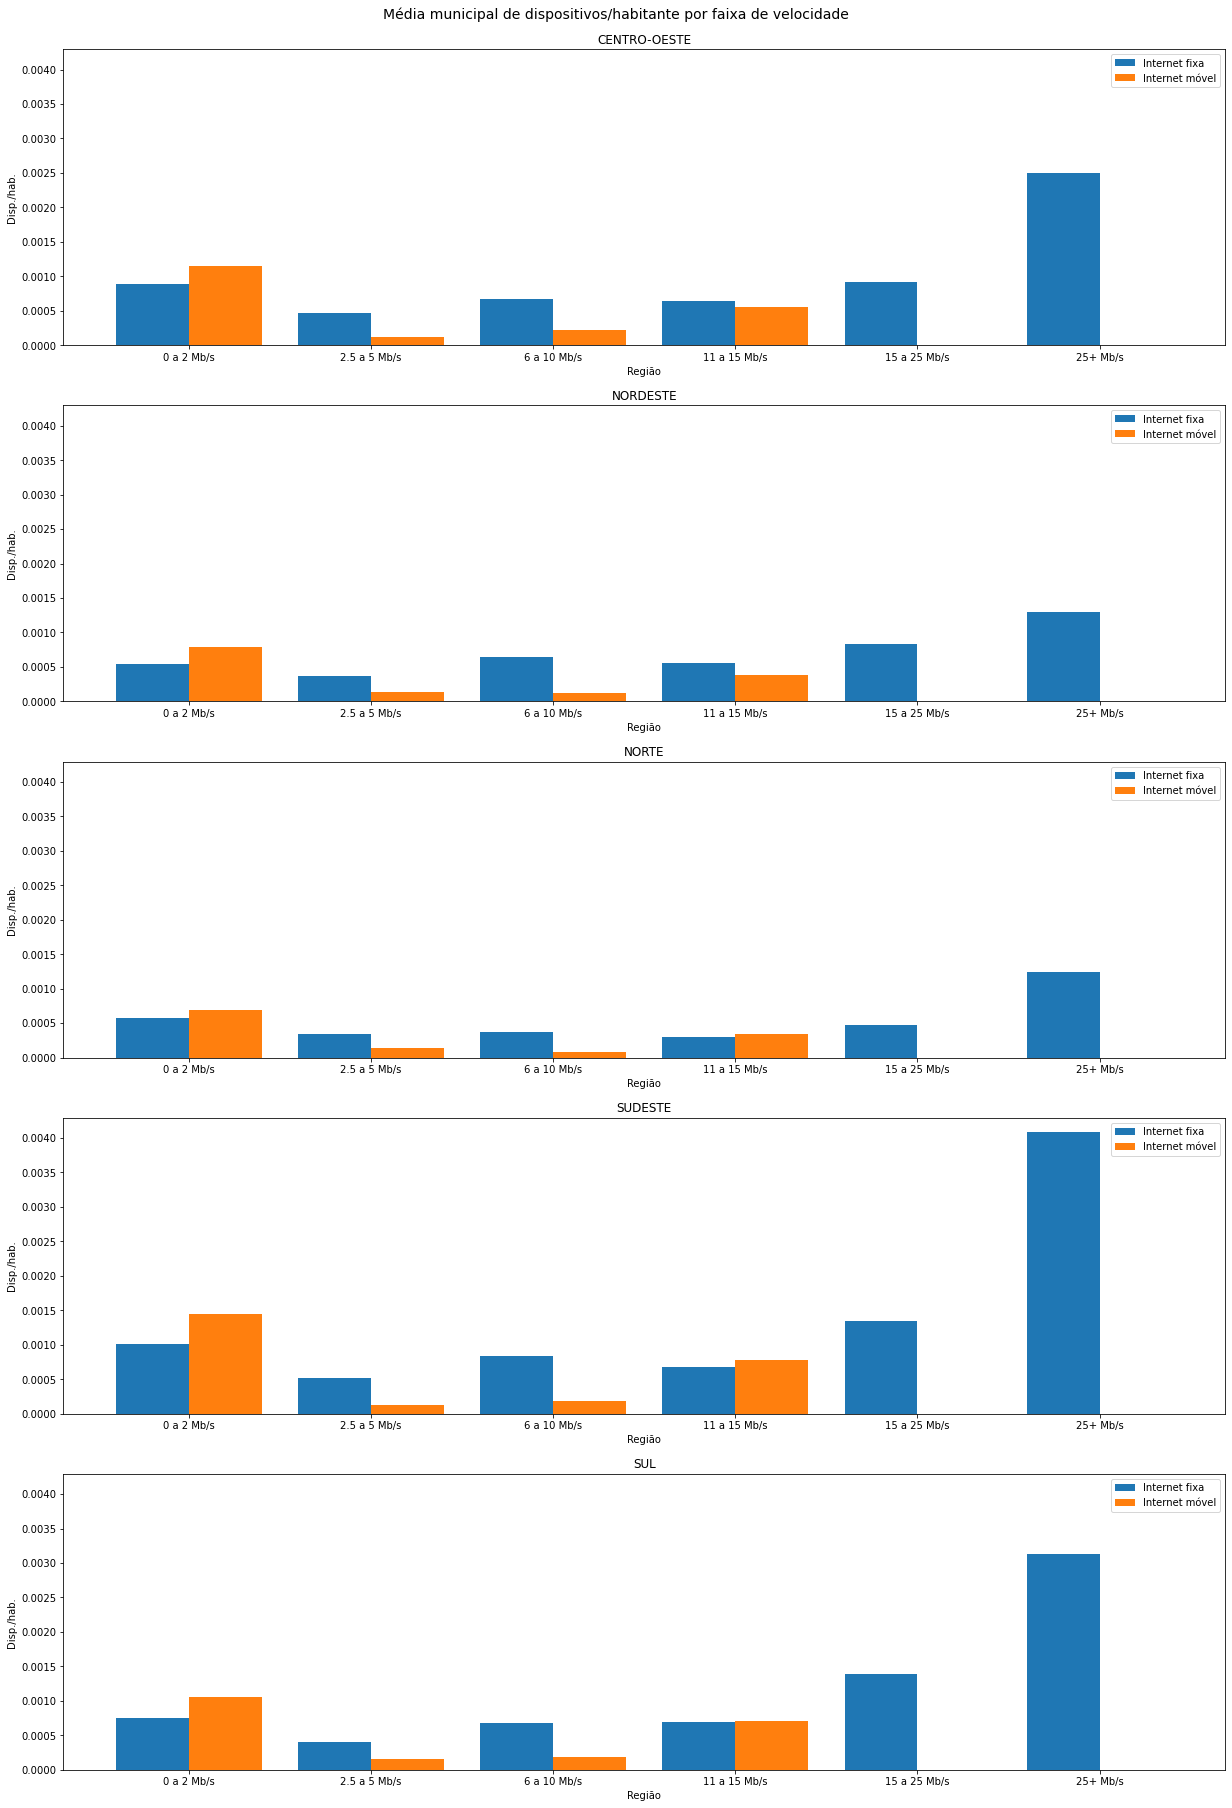

In [46]:
distribuicao_dispositivos(
    df=df,
    title='Média municipal de dispositivos/habitante por faixa de velocidade'
)

#### Distribuição de média de operadoras por região

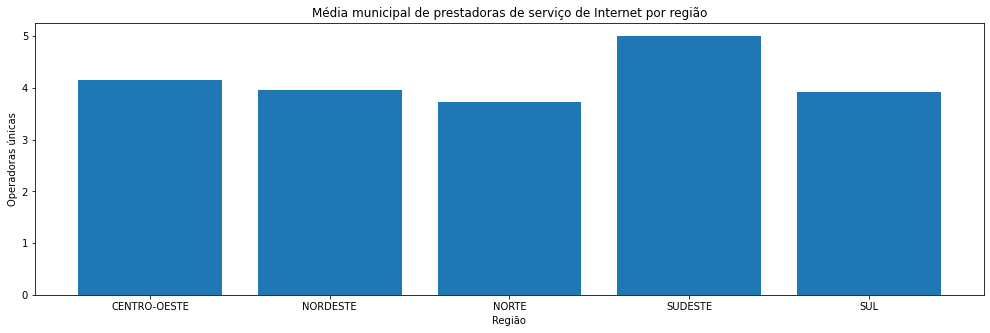

In [47]:
distribuicao_operadoras(
    df=df,
    title=u'Média municipal de prestadoras de serviço de Internet por região'
)

#### Conclusões

Nesta seção, observamos que a distribuição de dispositivos por tipo e faixa de velocidade evidenciam que a banda larga fixa é, em média, mais rápida que as redes móveis; e que a maioria dos dispositivos observados nas faixas mais baixas de velocidade é do tipo rede móvel. Isto corrobora as estimativas publicadas pelas plataformas [Statista](https://www.statista.com/statistics/1135124/brazil-internet-speed/) e [Speedtest](https://www.speedtest.net/global-index/brazil), que afirmam que as redes fixas de fato apresentam desempenho médio superior às redes móveis. Geograficamente, os acessos de velocidade superior estão concentrados nas regiões Sul e Sudeste; esta última região, inclusive, possui aproximadamente o triplo de dispositivos por habitante nas faixas superiores de velocidade (15 a 25, 25+ Mbps) se comparada às regiões Norte e Nordeste.

Além disso, estimamos a contagem de operadoras únicas de Internet por região como *proxy* para a infraestrutura de comunicações disponível em cada município. Ao agregarmos em nível regional, novamente nota-se que, caracteristicamente, municípios da região Sudeste possuem mais opções de prestadores de serviço do que municípios de outras regiões – em especial da Norte; entre as demais, as diferenças são menos significativas. Assim, os dados apontam para a possibilidade de que a região Norte esteja aquém das demais em termos de infraestrutura. De fato, considerados os desafios geográficos fisicamente impostos pela região, este seria o resultado esperado.

## 3.3. Indicadores sociais

### Visão geral

As colunas do conjunto de indicadores sociais são todas numéricas e contínuas. Suas unidades de medida são

| Variável  | Unidade de medida     | Observações     |
| :-------- | --------------------- | ------------------ |
| `populacao` | Número de indivíduos | Dados do Censo de 2010 |
| `exp_vida`  | Média de anos | Esperança de vida ao nascer |
| `analfabetismo` | Analfabetos por 1000 habitantes | Pessoas que de 15 anos ou mais que não sabem ler ou escrever ao menos um bilhete simples |
| `tx_pobreza` | Percentual da população | Pessoas vivendo com menos de USD 5,5 PPC (paridade de poder de compra) por mês |
| `pib_per_capita` | Milhares de BRL por habitante | Em BRL (2016) |
| `mortalidade_inf` | Mortalidade de crianças por 1000 habitantes | Considera crianças que morreram antes de completar 1 ano de vida | 
| `maternidade_inf` | Percentual de meninas que tiveram filhos | Meninas de 10 a 14 anos de idade |

In [48]:
df[cols_social].drop_duplicates(subset=cols_social).describe()

,populacao,exp_vida,analfabetismo,tx_pobreza,pib_per_capita,mortalidade_inf,maternidade_inf
count,3.519000e+03,3519.000000,3519.000000,3518.000000,3519.000000,3479.000000,2570.000000
mean,4.960086e+04,73.479639,14.497772,19.983215,15.292072,12.535979,1.144510
std,2.541274e+05,2.619600,9.534695,16.553294,13.894857,10.020311,0.814985
min,1.096000e+03,65.490000,0.950000,0.190000,3.220000,0.000000,0.050000
25%,8.506500e+03,71.600000,6.935000,5.922500,6.800000,6.670000,0.542500
50%,1.709300e+04,73.890000,11.120000,13.080000,11.980000,11.630000,0.940000
75%,3.433550e+04,75.470000,21.890000,34.170000,18.960000,16.850000,1.500000
max,1.125350e+07,78.640000,42.860000,67.870000,208.900000,142.860000,6.110000


### Visualização dos dados

In [49]:
def histograma_social(df, key, title, xlabel, ylabel=u'Frequência', legend=None, regional=False, agg_method=None, bins=None):
    df = df.dropna()
    fig, ax = plt.subplots(figsize=(15, 5))
    
    if not regional:
        if bins is not None:
            ax.hist(df[key], edgecolor='black', bins=bins)
        else:
            ax.hist(df[key], edgecolor='black')
        ax.axvline(df[key].mean(), color='red', linestyle='--')
    else:
        df.groupby('regiao').agg({
            key: agg_method
        }).plot.bar(ax=ax)
        if legend:
            ax.legend([legend])
        else:
            ax.get_legend().remove()
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
        
    plt.title(title, fontsize=14)
    plt.show()

#### População por região

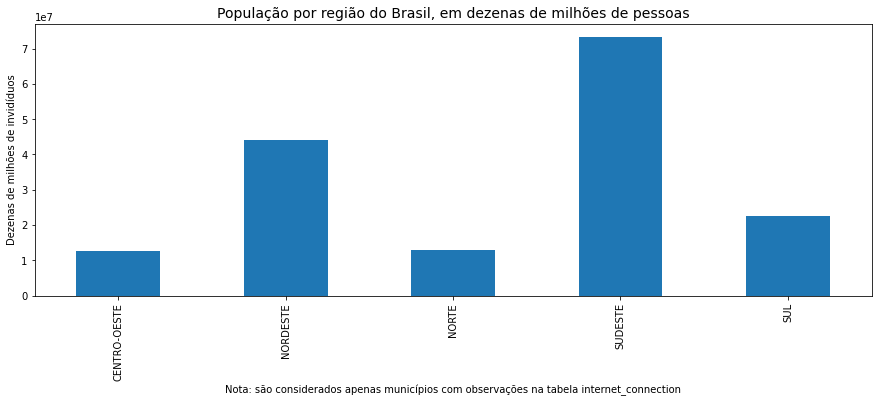

In [50]:
histograma_social(
    df=df[cols_social + ['regiao']].drop_duplicates(),
    key='populacao',
    xlabel=u'Nota: são considerados apenas municípios com observações na tabela internet_connection',
    ylabel=u'Dezenas de milhões de invidíduos',
    title=u'População por região do Brasil, em dezenas de milhões de pessoas',
    regional=True,
    agg_method='sum'
)

#### Expectativa de vida

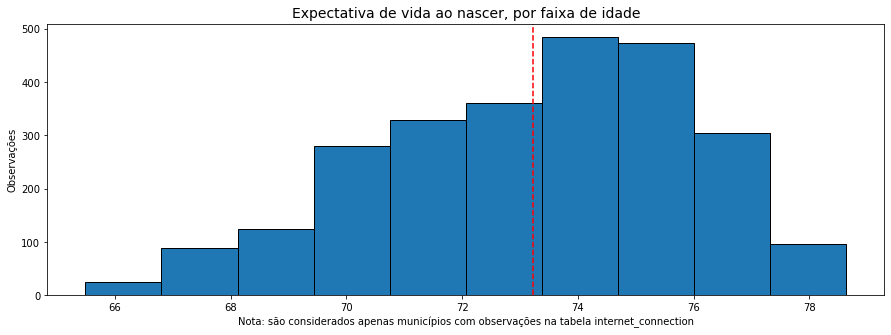

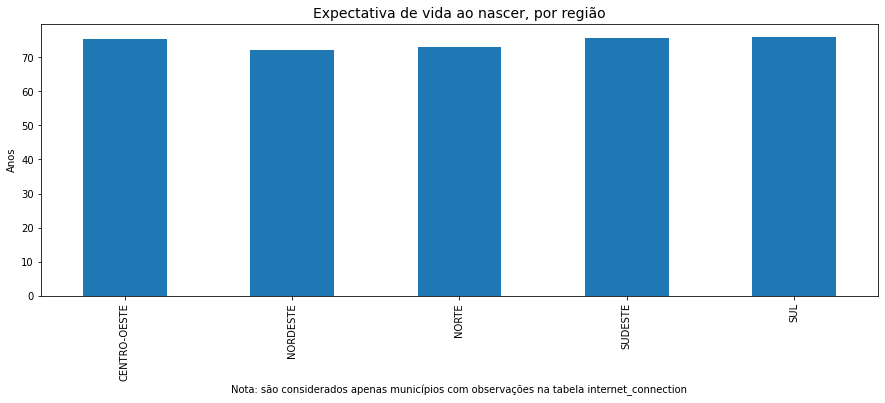

In [51]:
histograma_social(
    df=df[cols_social].drop_duplicates(),
    key='exp_vida',
    xlabel=u'Nota: são considerados apenas municípios com observações na tabela internet_connection',
    ylabel=u'Observações',
    title=u'Expectativa de vida ao nascer, por faixa de idade'
)

histograma_social(
    df=df[cols_social + ['regiao']].drop_duplicates(),
    key='exp_vida',
    xlabel=u'Nota: são considerados apenas municípios com observações na tabela internet_connection',
    ylabel=u'Anos',
    title=u'Expectativa de vida ao nascer, por região',
    regional=True,
    agg_method=lambda x: np.average(x, weights=df.loc[x.index, 'populacao'])
)

#### Analfabetismo

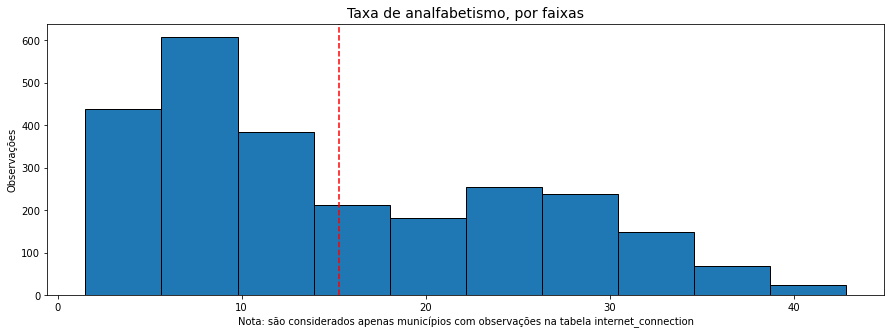

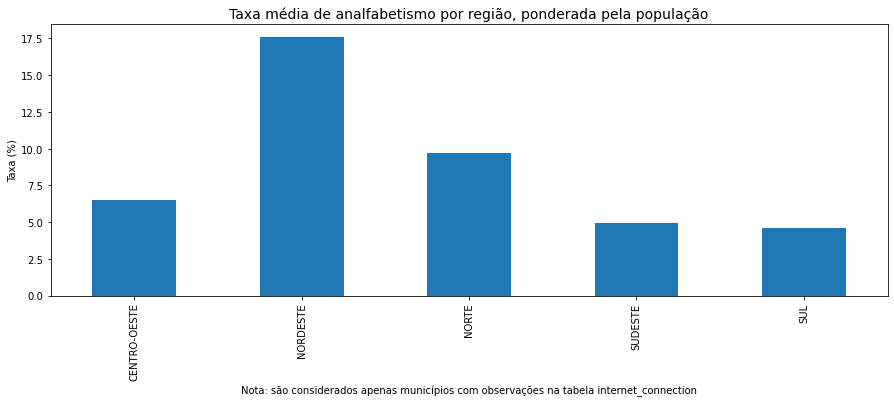

In [54]:
histograma_social(
    df=df[cols_social].drop_duplicates(),
    key='analfabetismo',
    xlabel=u'Nota: são considerados apenas municípios com observações na tabela internet_connection',
    ylabel=u'Observações',
    title=u'Taxa de analfabetismo, por faixas'
)

histograma_social(
    df=df[cols_social + ['regiao']].drop_duplicates(),
    key='analfabetismo',
    xlabel=u'Nota: são considerados apenas municípios com observações na tabela internet_connection',
    ylabel=u'Taxa (%)',
    title=u'Taxa média de analfabetismo por região, ponderada pela população',
    regional=True,
    agg_method=lambda x: np.average(x, weights=df.loc[x.index, 'populacao'])
)

#### Taxa de Pobreza

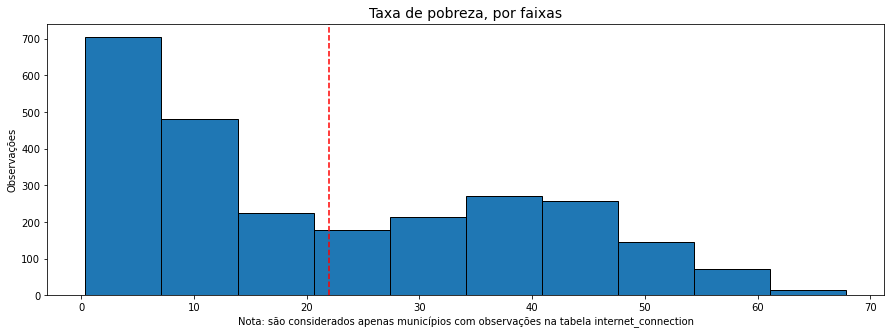

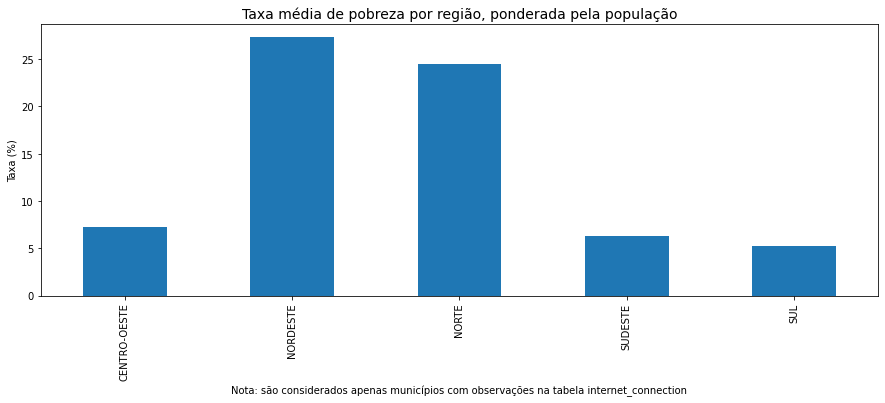

In [55]:
histograma_social(
    df=df[cols_social].drop_duplicates(),
    key='tx_pobreza',
    xlabel=u'Nota: são considerados apenas municípios com observações na tabela internet_connection',
    ylabel=u'Observações',
    title=u'Taxa de pobreza, por faixas'
)

histograma_social(
    df=df[cols_social + ['regiao']].drop_duplicates(),
    key='tx_pobreza',
    xlabel=u'Nota: são considerados apenas municípios com observações na tabela internet_connection',
    ylabel=u'Taxa (%)',
    title=u'Taxa média de pobreza por região, ponderada pela população',
    regional=True,
    agg_method=lambda x: np.average(x, weights=df.loc[x.index, 'populacao'])
)

#### PIB per capita

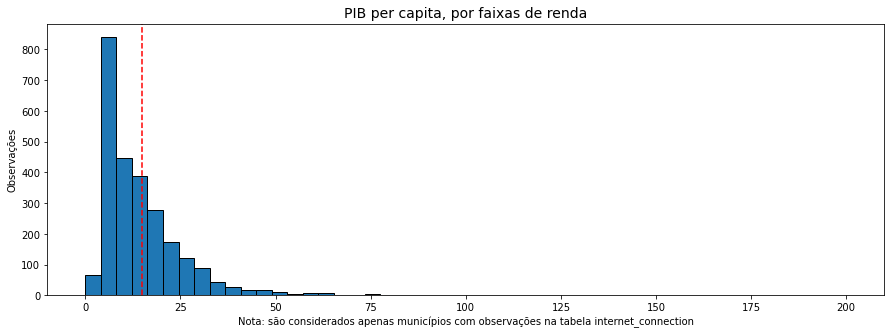

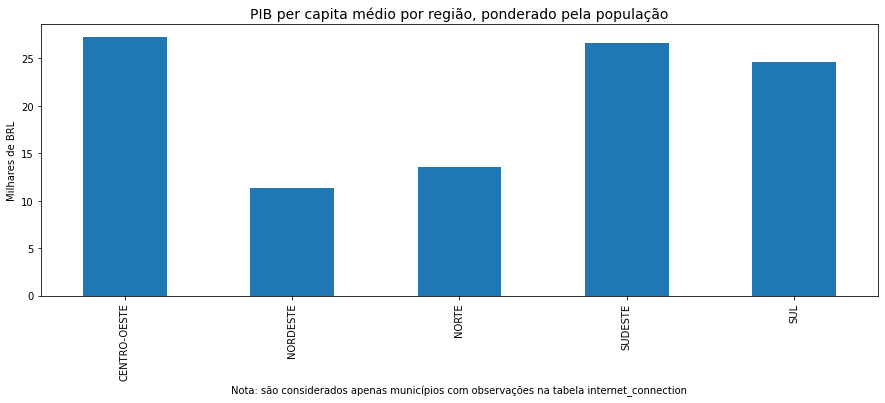

In [56]:
histograma_social(
    df=df[cols_social].drop_duplicates(),
    key='pib_per_capita',
    xlabel=u'Nota: são considerados apenas municípios com observações na tabela internet_connection',
    ylabel=u'Observações',
    title=u'PIB per capita, por faixas de renda',
    bins=np.linspace(0, 200, 50)
)

histograma_social(
    df=df[cols_social + ['regiao']].drop_duplicates(),
    key='pib_per_capita',
    xlabel=u'Nota: são considerados apenas municípios com observações na tabela internet_connection',
    ylabel=u'Milhares de BRL',
    title=u'PIB per capita médio por região, ponderado pela população',
    regional=True,
    agg_method=lambda x: np.average(x, weights=df.loc[x.index, 'populacao'])
)

#### Mortalidade infantil

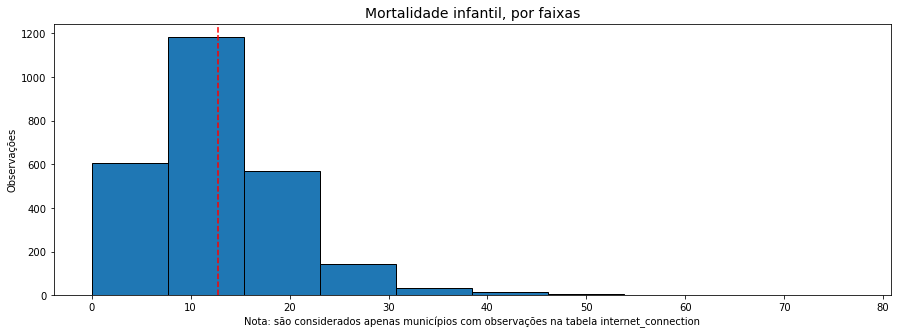

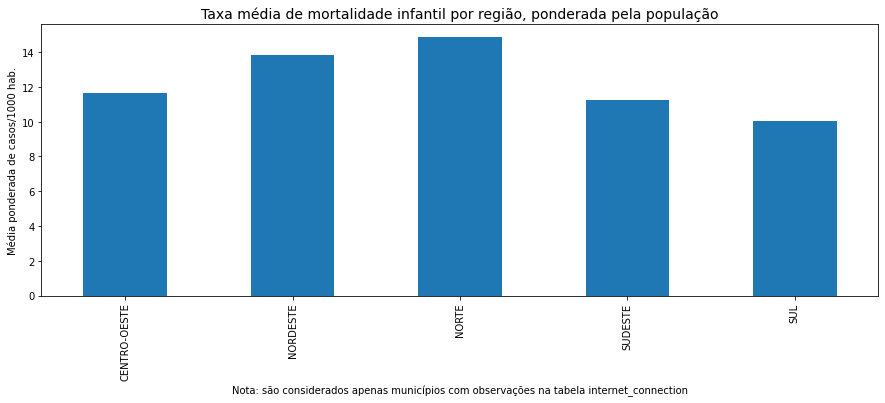

In [57]:
histograma_social(
    df=df[cols_social].drop_duplicates(),
    key='mortalidade_inf',
    xlabel=u'Nota: são considerados apenas municípios com observações na tabela internet_connection',
    ylabel=u'Observações',
    title=u'Mortalidade infantil, por faixas'
)

histograma_social(
    df=df[cols_social + ['regiao']].drop_duplicates(),
    key='mortalidade_inf',
    xlabel=u'Nota: são considerados apenas municípios com observações na tabela internet_connection',
    ylabel=u'Média ponderada de casos/1000 hab.',
    title=u'Taxa média de mortalidade infantil por região, ponderada pela população',
    regional=True,
    agg_method=lambda x: np.average(x, weights=df.loc[x.index, 'populacao'])
)

#### Gravidez na adolescência

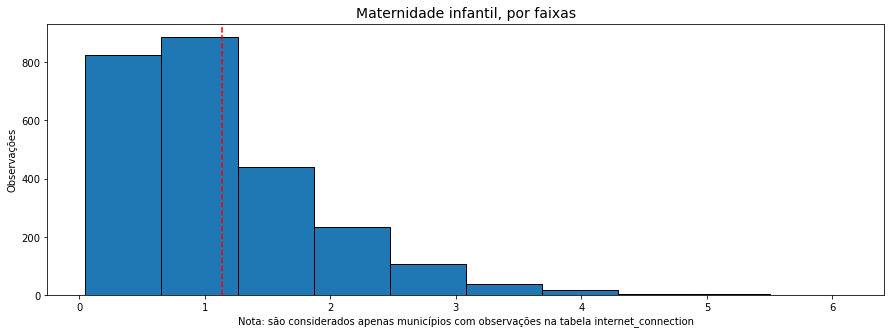

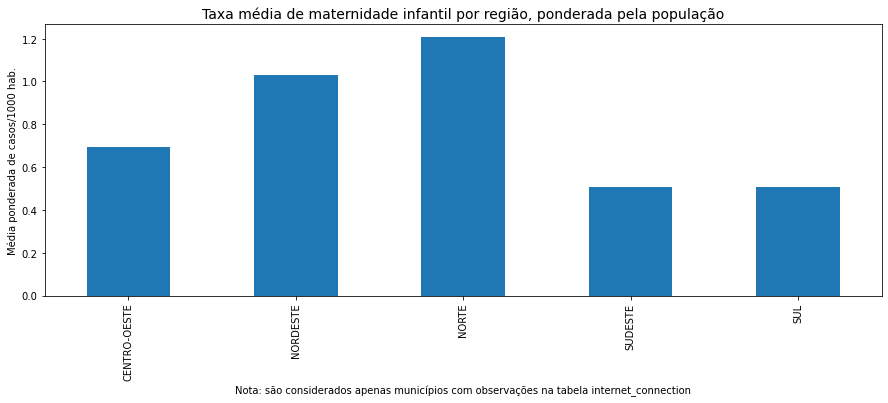

In [58]:
histograma_social(
    df=df[cols_social].drop_duplicates(),
    key='maternidade_inf',
    xlabel=u'Nota: são considerados apenas municípios com observações na tabela internet_connection',
    ylabel=u'Observações',
    title=u'Maternidade infantil, por faixas'
)

histograma_social(
    df=df[cols_social + ['regiao']].drop_duplicates(),
    key='maternidade_inf',
    xlabel=u'Nota: são considerados apenas municípios com observações na tabela internet_connection',
    ylabel=u'Média ponderada de casos/1000 hab.',
    title=u'Taxa média de maternidade infantil por região, ponderada pela população',
    regional=True,
    agg_method=lambda x: np.average(x, weights=df.loc[x.index, 'populacao'])
)

### Conclusões

Os indicadores sociais apresentados servirão de variáveis de controle para a regressão. Antes que apresentemos qualificações sobre as regiões, é necessário frisar que os resultados apresentam certo viés que favorece as regiões Sul e Sudeste: como consideramos apenas as cidades que possuam ao menos 1 registro de teste de velocidade – e dada a concentração da infraestrutura de Internet nessa região –, existirão mais observações para cidades pertencentes a este eixo. Assim, os conclusões devem ser interpretadas com cautela.

Em termos de indicadores, nota-se que o Sudeste, além de concentrar a maior população considerada, também concentra os melhores resultados em todos os indicadores considerados, e o Sul tem desempenho similar. As regiões Norte e Nordeste, por outro lado, encontram-se na situação oposta: seus resultados são todos inferiores às regiões anteriores. A isto certamente está associada a distribuição de riqueza per capita no país, que está diretamente correlacionada ao bom desempenho nestes indicadores. Como caso atípico ao padrão constatado, temos apenas a expectativa de vida: apesar de todas as disparidades pontuadas, a esperança de vida média é muito similar entre todas as regiões – e a amplitude de observações é menor que a das demais variáveis.

## 3.4. Correlações entre Internet e Educação

Partimos da hipótese de que a maior prevalência de dispositivos em faixas superiores de velocidade de acesso à Internet contribui positivamente para indicadores educacionais, em especial aos que se referem ao Ensino Médio – dada a maior autonomia exigida dos estudantes deste nível. Assim, analisamos a matriz de correlações e constatamos que a relação entre variáveis de acesso à Internet e indicadores educacionais é muito pouco significativa – não há correlação absoluta que supere o patamar de **0.1** entre variáveis destes grupos. De fato, as correlações mais significativas são observadas apenas em variáveis intragrupais, conforme esperado.

A seguir, respectivamente, a matriz de correlações e sua representação gráfica.

In [59]:
cols_corr = cols_internet + ['num_operadoras'] + [x for x in cols_educacao if '_em' in x]

### Matriz de correlações

In [60]:
df[cols_corr].corr()

,0_a_2_mbs,2.5_a_5_mbs,6_a_10_mbs,11_a_15_mbs,15_a_25_mbs,acima_25_mbs,num_operadoras,tx_aprov_em,saeb_mat_em,saeb_port_em,ideb_em
0_a_2_mbs,1.000000,0.342900,0.384413,0.496404,0.408979,0.492633,0.418837,-0.055721,0.096247,0.142191,0.049421
2.5_a_5_mbs,0.342900,1.000000,0.473211,0.382955,0.441703,0.435693,0.384810,-0.052190,0.026331,0.052425,-0.005176
6_a_10_mbs,0.384413,0.473211,1.000000,0.490774,0.548838,0.518002,0.431325,-0.052087,0.023829,0.056233,-0.004495
11_a_15_mbs,0.496404,0.382955,0.490774,1.000000,0.503303,0.443542,0.392190,-0.049422,0.038653,0.077242,0.008838
15_a_25_mbs,0.408979,0.441703,0.548838,0.503303,1.000000,0.705095,0.492452,-0.033175,0.069907,0.095881,0.039859
acima_25_mbs,0.492633,0.435693,0.518002,0.443542,0.705095,1.000000,0.619558,-0.019299,0.111072,0.151299,0.082562
num_operadoras,0.418837,0.384810,0.431325,0.392190,0.492452,0.619558,1.000000,-0.032553,0.012448,0.059982,0.000942
tx_aprov_em,-0.055721,-0.052190,-0.052087,-0.049422,-0.033175,-0.019299,-0.032553,1.000000,0.207045,0.214321,0.721562
saeb_mat_em,0.096247,0.026331,0.023829,0.038653,0.069907,0.111072,0.012448,0.207045,1.000000,0.937004,0.797545
saeb_port_em,0.142191,0.052425,0.056233,0.077242,0.095881,0.151299,0.059982,0.214321,0.937004,1.000000,0.803076


#### Visualização da Matriz de Correlações
*Nota: os plots de interesse estão entre as linhas 1 a 7, colunas 8 a 11*

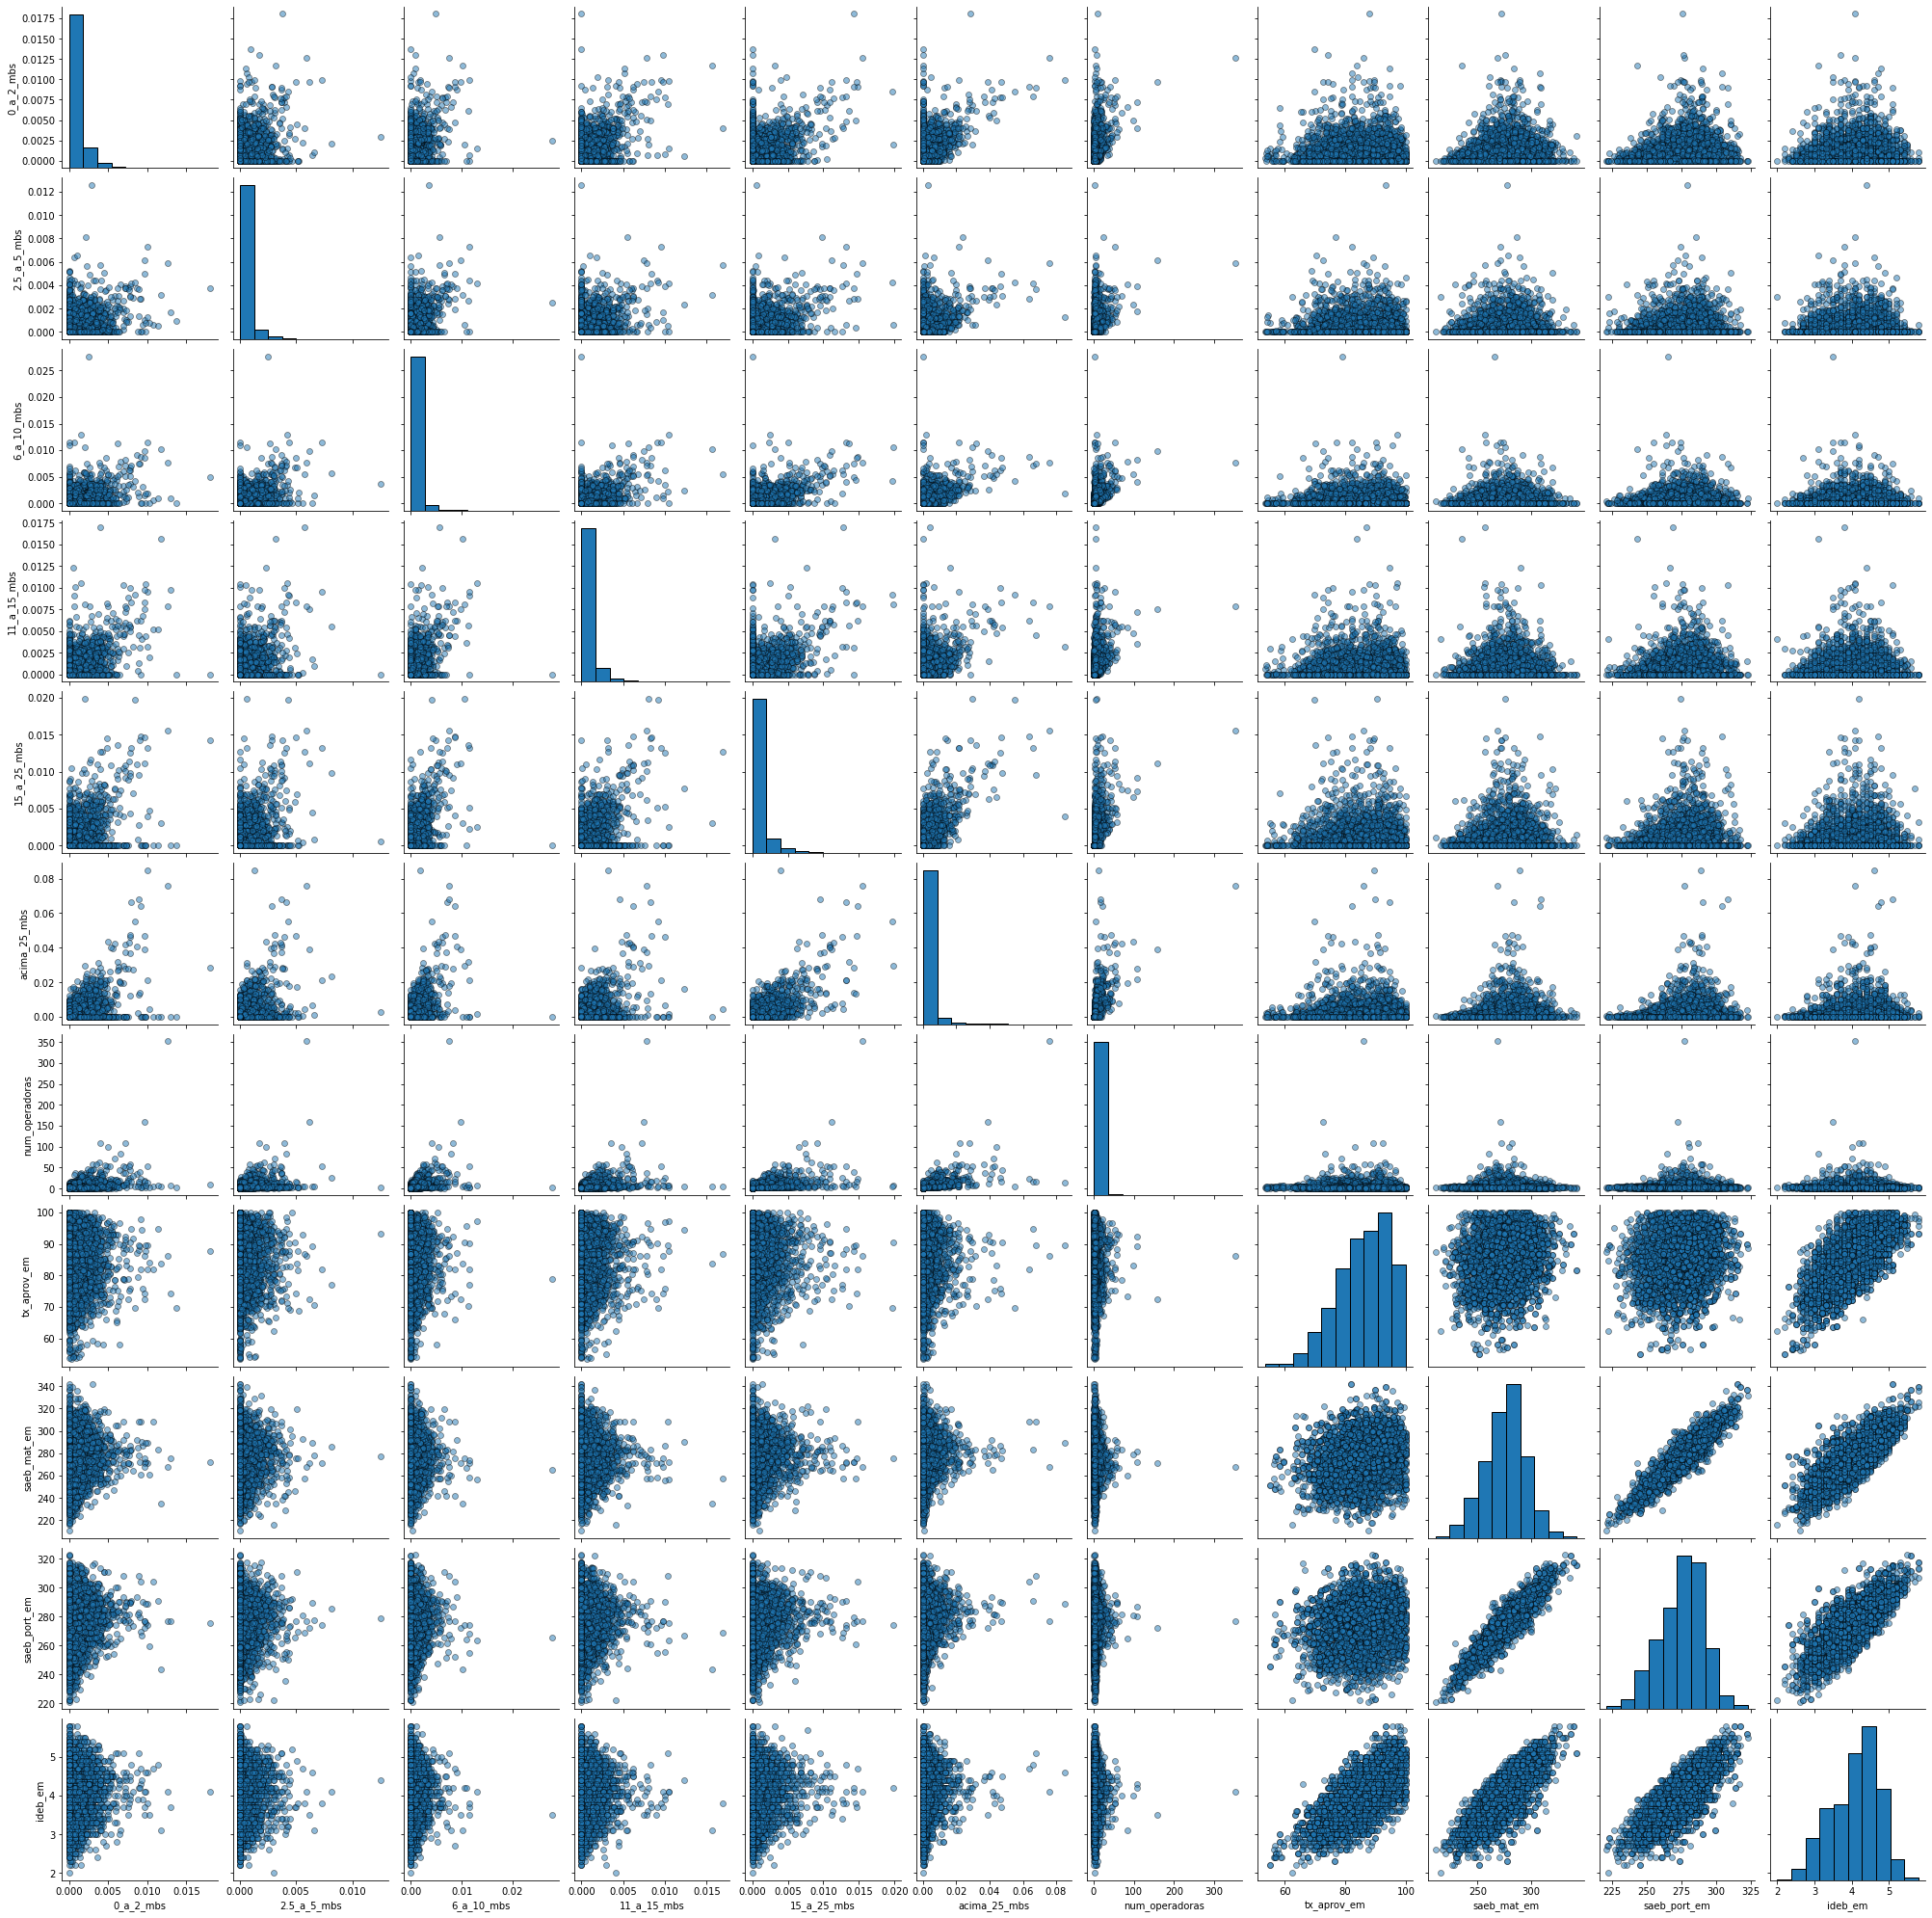

In [61]:
pairplot = sns.pairplot(
    df[cols_corr],
    diag_kws={'edgecolor':'k'},
    plot_kws={'alpha':0.5, 'edgecolor':'k'}
)
plt.show()